In [1]:
import gzip
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.measure
from typing import List
from matplotlib.gridspec import GridSpec
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization import MinMaxInterval, PercentileInterval
from astropy.visualization import LogStretch, LinearStretch
from PIL import Image
from astropy.wcs import WCS

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load stamp from FITS

In [2]:
with fits.open("c4d_150903_015948_osi_VR_v1_extn=6_POS=279.11515312333336,10.34555727_SIZE=0.1,0.1.fits", memmap=False, ignore_missing_simple=True) as hdu:
    im = hdu[0].data
    header = hdu[0].header
    
offset = (763, 300)
size_full_img = 128  # pixels
im = im[offset[0]:offset[0]+size_full_img, offset[1]:offset[1]+size_full_img]

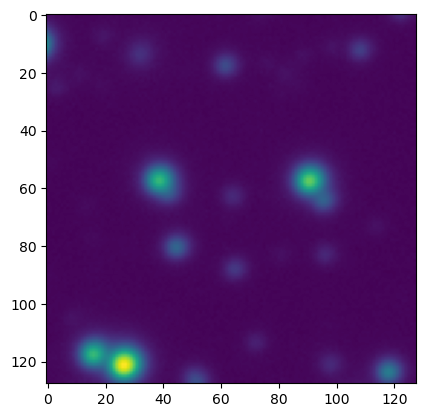

In [3]:
plt.imshow(np.arcsinh(im))

## Stamp to multiscale

In [4]:
n_levels = 4

In [5]:
def build_multiscale_from_image(image: np.array) -> List[np.array]:
    ministamp_size = int(np.ceil(image.shape[0] / 2**(n_levels-1)))
    print(f'ministamp pixel size {ministamp_size}')
    im_aux = image.copy()  # full FoV, progressive lower quality
    ministamps = []
    for level in range(n_levels):
        im_aux_size = im_aux.shape[0]
        center = int(np.ceil(im_aux_size/2))
        center_start = center - ministamp_size // 2
        center_end = center + ministamp_size // 2
        center_ministamp = im_aux[center_start:center_end, center_start:center_end]
        ministamps.append(center_ministamp)
        im_aux = skimage.measure.block_reduce(im_aux, (2, 2), np.sum)
    return ministamps

ministamp pixel size 16


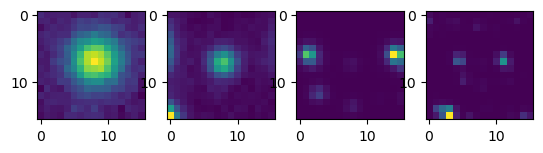

In [6]:
ministamps = build_multiscale_from_image(im)

for level in range(n_levels):
    plt.subplot(1, n_levels, level+1)
    plt.imshow(ministamps[level])

## Save multiscale stamp

In [7]:
def multiscale_images_to_npz(ministamps: List[np.array], filename: str):
    serialized_holey = []
    serialized_holey.append(ministamps[0].copy())
    for level in range(1, n_levels):
        # we don't need to save the centers
        top = ministamps[level][:4, :]
        left = ministamps[level][4:12, :4]
        right = ministamps[level][4:12, -4:]
        bottom = ministamps[level][-4:, :]

        serialized_holey.append(top)
        serialized_holey.append(left)
        serialized_holey.append(right)
        serialized_holey.append(bottom)

    np.savez(filename, *serialized_holey)

In [8]:
multiscale_images_to_npz(ministamps, 'multiscale_stars.npz')

## Load multiscale stamp

In [9]:
def ministamps_from_npz(filename):
    ministamps = []
    npz_holey = np.load(filename)
    ministamps.append(npz_holey['arr_0'])
    for level in range(1, n_levels):
        top = npz_holey[f'arr_{4*level-3}']
        left = npz_holey[f'arr_{4*level-2}']
        right = npz_holey[f'arr_{4*level-1}']
        bottom = npz_holey[f'arr_{4*level}']
        
        ministamp = np.zeros(ministamps[0].shape, dtype=np.float32)
        ministamp[:4, :] = top
        ministamp[4:12, :4] = left
        ministamp[4:12, -4:] = right
        ministamp[-4:, :] = bottom
        ministamps.append(ministamp)
        
    rebuilt_ministamps = []
    rebuilt_ministamps.append(ministamps[0].copy())
    for level in range(1, n_levels):
        stamp = ministamps[level].copy()
        stamp[4:12, 4:12] = skimage.measure.block_reduce(
            rebuilt_ministamps[level-1], (2, 2), np.sum)
        rebuilt_ministamps.append(stamp)
    
    return rebuilt_ministamps

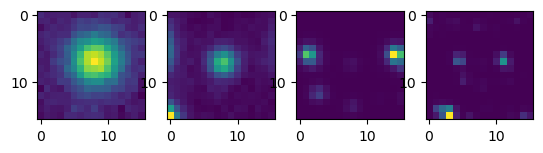

In [10]:
rebuilt_ministamps = ministamps_from_npz('multiscale_stars.npz')

for level in range(n_levels):
    plt.subplot(1, n_levels, level+1)
    plt.imshow(rebuilt_ministamps[level])

## Check that values did not change

In [11]:
[(ministamps[level] == rebuilt_ministamps[level]).all() for level in range(n_levels)]

[True, True, True, True]

## Visualization

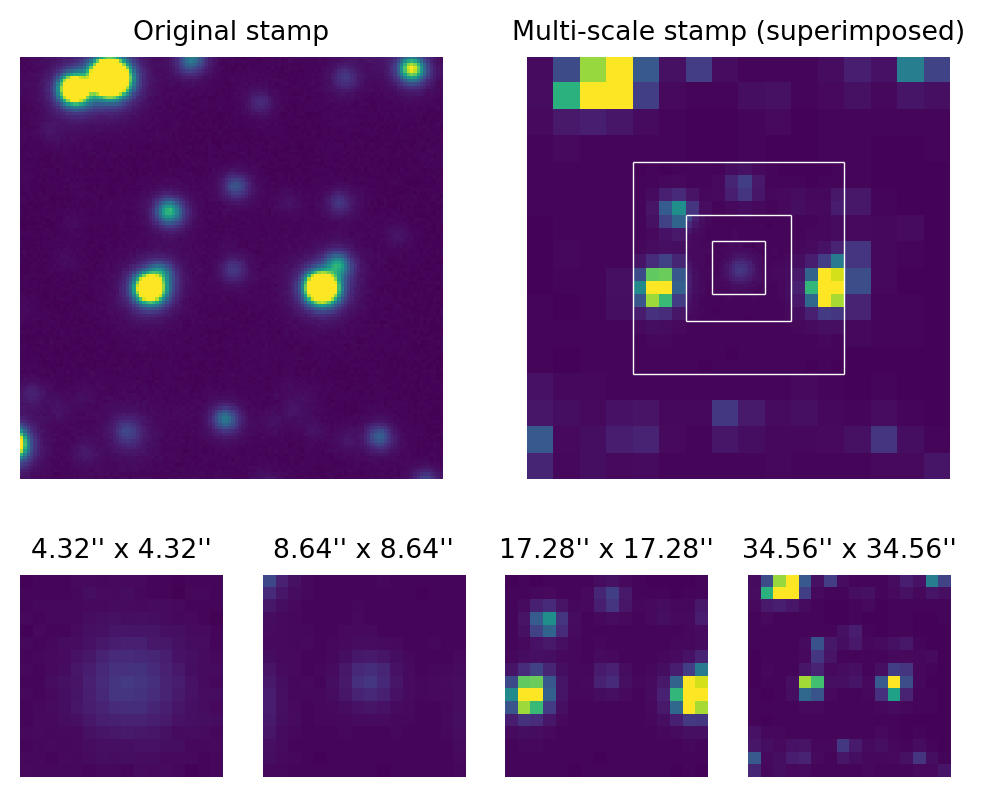

In [12]:
fig = plt.figure(figsize=(6, 4), dpi=200)
plt.rcParams.update({'font.size': 8})

gs1 = GridSpec(1, 2, bottom=0.32, top=1.0)
gs2 = GridSpec(1, 4, bottom=0.0, top=0.3)

stamp = im
multiscale_stamp = np.stack(rebuilt_ministamps, axis=-1)

interval = ZScaleInterval(contrast=0.03)
vmin, vmax = interval.get_limits(stamp)
norm = ImageNormalize(vmin=vmin, vmax=vmax)
cmap = matplotlib.colormaps['viridis']

for scale in range(4):
    ax = fig.add_subplot(gs2[0, scale])
    ax.imshow(
        multiscale_stamp[:, :, scale] / 4**(scale), 
        cmap=cmap, norm=norm, origin='lower', 
        interpolation='nearest') #, extent=[0, 8, 0, 8])
    #ax.set_xticks(range(1, 5))
    ax.axis('off')
    ax.set_title(f"{0.27*16*2**scale}'' x {0.27*16*2**scale}''")

ax = fig.add_subplot(gs1[0, 0])
ax.imshow(stamp, cmap=cmap, norm=norm, origin='lower', interpolation='nearest')

ax.set_title('Original stamp')
ax.axis('off')

ax = fig.add_subplot(gs1[0, 1])
rebuild = np.array(Image.fromarray(multiscale_stamp[:, :, 3]/4**3).resize((128, 128), Image.Resampling.NEAREST))
rebuild[32:96, 32:96] = np.array(Image.fromarray(multiscale_stamp[:, :, 2]/4**2).resize((64, 64), Image.Resampling.NEAREST))
rebuild[48:80, 48:80] = np.array(Image.fromarray(multiscale_stamp[:, :, 1]/4).resize((32, 32), Image.Resampling.NEAREST))
rebuild[56:72, 56:72] = np.array(Image.fromarray(multiscale_stamp[:, :, 0]).resize((16, 16), Image.Resampling.NEAREST))

a = np.array([32, 96, 48, 80, 56, 72])
b = np.array([32, 32, 48, 48, 56, 56])
c = np.array([96, 96, 80, 80, 72, 72])

plt.vlines(
    a-0.5, 
    b-0.5, 
    c-0.5, colors='white', linewidth=0.5)

plt.hlines(
    a-0.5, 
    b-0.5, 
    c-0.5, colors='white', linewidth=0.5)


ax.imshow(rebuild, cmap=cmap, norm=norm, origin='lower', interpolation='nearest')
ax.set_title('Multi-scale stamp (superimposed)')
ax.axis('off');

## Create multi-scale FITS file

Data cube

In [13]:
fits.writeto(
    'multiscale_cube.fits', 
    multiscale_stamp.transpose(2, 0, 1),
    overwrite=True
)

multi-extension FITS

### Something like this (?)

In [14]:
def wcs_scale(original_header, offset, im_size, level, n_levels):
    """
    original_header: header of the original FITS.
    offset: offset of larger FoV stamp in small pixel res.
    im_size: large FoV stamp size in pixels for small pixel res.
    level: from 0 to n_levels-1. 0 is largest FoV.
    n_levels: number of levels or scales.
    """
    wcs = WCS(original_header)
    wcs.wcs.crpix -= offset
    wcs.wcs.cd *= 2**(n_levels - level - 1)
    extra_offset_small_pix = 0
    for i in range(level):
        extra_offset_small_pix += (im_size // 4) / 2**i
    wcs.wcs.crpix -= int(extra_offset_small_pix)
    wcs.wcs.crpix /= 2**(n_levels - level - 1)
    return wcs

In [15]:
hdu_py_list = []

for scale in range(n_levels):
    size_full_img
    wcs = wcs_scale(header, offset, size_full_img, scale, n_levels)
    scale_header = wcs.to_header()
    if scale == 0:
        hdu = fits.PrimaryHDU(multiscale_stamp[:, :, n_levels - scale - 1], header=scale_header)
    else:
        hdu = fits.ImageHDU(multiscale_stamp[:, :, n_levels - scale - 1], header=scale_header)
    hdu_py_list.append(hdu)
        
hdul = fits.HDUList(hdu_py_list)
hdul.writeto('multiscale_multiextension.fits', overwrite=True)